# Setup

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from ModelSingles import SingleClass
import funs
import figs

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Test that numba is working
# It should throw an error
from numba import njit
@njit(parallel=True)
def test():
    return [1, [2]]
test()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mType of variable '$0.4' cannot be determined, operation: build_list(items=[Var($const0.1, <ipython-input-3-19cbeaaedfea> (6)), Var($0.3, <ipython-input-3-19cbeaaedfea> (6))]), location: <ipython-input-3-19cbeaaedfea> (6)
[1m
File "<ipython-input-3-19cbeaaedfea>", line 6:[0m
[1mdef test():
[1m    return [1, [2]]
[0m    [1m^[0m[0m
[0m
This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


# Solution

In [25]:
model = SingleClass()
model.solve()

# Simulation

In [10]:
model.par.simN = 100000
states = [0]*0 + [1]*30 + [2]*730 + [3]*240 + [4]*0 + [5]*50 + [6]*800 + [7]*150
model.par.simStates = np.array(states*50)

### Wealth distribution

A skewed wealth distribution seems most realistic

In [11]:
np.random.seed(2019)
dev = 1.25
M_init = np.random.lognormal(-0.5*(dev**2),dev,size=model.par.simN)+0.8
model.par.simM_init = M_init
print('median:',np.round(np.median(M_init),3))
print('mean:  ',np.round(np.mean(M_init),3))
print('std:   ',np.round(np.std(M_init),3))

median: 1.258
mean:   1.803
std:    1.867


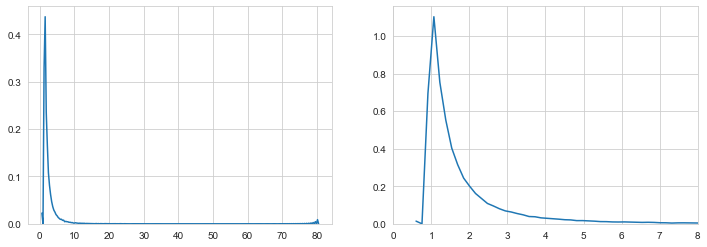

In [12]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.kdeplot(M_init,ax=axs[0],gridsize=200)
axs[1].set_xlim(0,8)
sns.kdeplot(M_init,ax=axs[1],gridsize=500)
plt.show()

### Euler errors

In [13]:
model.simulate(euler=True)

In [14]:
def log_euler(model,states='all',time='all'):
    
    rows = len(model.sim.euler)    
    
    if states == 'all':
        log_abs = np.log10(abs(model.sim.euler / model.sim.c[:rows]))
    else:
        log_abs = np.log10(abs(model.sim.euler[:,model.sim.states==states] / model.sim.c[:rows,model.sim.states==states]))
    
    if time == 'all':
        return np.round(np.nanmean(log_abs),3)
    else:
        tmp = np.nanmean(log_abs,axis=1)
        return np.round(tmp[time],3)

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


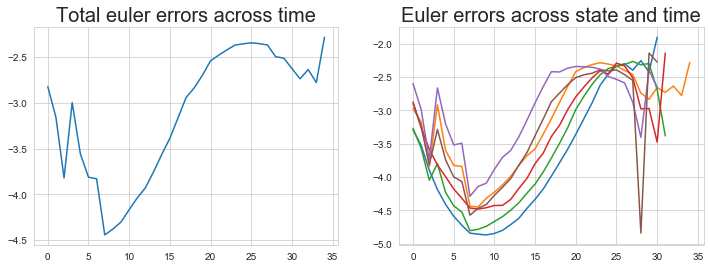

In [15]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
all_times = list(range(len(model.sim.euler)))
axs[0].set_title('Total euler errors across time',size=20)
axs[0].plot(log_euler(model,time=all_times))

axs[1].set_title('Euler errors across state and time',size=20)
for st in np.unique(model.sim.states):
    axs[1].plot(log_euler(model,states=st,time=all_times))

plt.show()

In [16]:
print('Total euler error:',np.round(log_euler(model),3))

Total euler error: -3.544


Try to increase point on constraint (doesn't really affect the solution)

In [17]:
poc = [5,10,15,20,25,30]
store_5 = []
store = []

for pc in poc:
    model.par.poc = pc
    model.solve()
    model.simulate(euler=True)
    store_5.append(np.mean(log_euler(model,time=[0,1,2,3,4])))
    store.append(log_euler(model))
print('first 5 period:',store_5)
print('whole period:  ',store)
model.par.poc = 10 # reset

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


first 5 period: [-3.2725999999999997, -3.2718, -3.2718, -3.2716000000000003, -3.2716000000000003, -3.2716000000000003]
whole period:   [-3.544, -3.544, -3.544, -3.544, -3.544, -3.544]


Try to increase the points in the a grid (expected effect)

In [18]:
Na = [150,200,250,300,350,400]
store_5
store = []

for a in Na:
    model.par.Na = a
    model.solve()
    model.simulate(euler=True)
    store_5.append(np.mean(log_euler(model,time=[0,1,2,3,4])))
    store.append(log_euler(model))
print('first 5 period:',store_5)
print('whole period:  ',store)
model.par.Na = 150 # reset

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


first 5 period: [-3.2725999999999997, -3.2718, -3.2718, -3.2716000000000003, -3.2716000000000003, -3.2716000000000003, -3.2718, -3.472, -3.6926, -3.8174, -3.9378, -4.042999999999999]
whole period:   [-3.544, -3.826, -4.093, -4.312, -4.485, -4.638]


Try to increase a_max (remember most have 1.8 and few have up to 80).
This has actually huge effect

In [19]:
a_max = [2,5,10,20,50,100,150]
store = []

for a in a_max:
    model.par.a_max = a
    model.solve()
    model.simulate(euler=True)
    store_5.append(np.mean(log_euler(model,time=[0,1,2,3,4])))
    store.append(log_euler(model))
print('first 5 period:',store_5)
print('whole period:  ',store)
model.par.a_max = 100 # reset

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


first 5 period: [-3.2725999999999997, -3.2718, -3.2718, -3.2716000000000003, -3.2716000000000003, -3.2716000000000003, -3.2718, -3.472, -3.6926, -3.8174, -3.9378, -4.042999999999999, -5.1532, -5.2025999999999994, -4.8436, -4.3942, -3.7662, -3.2718, -2.9264]
whole period:   [-6.275, -6.148, -5.63, -5.036, -4.228, -3.544, -3.195]


Preferred specification

In [20]:
model.par.poc = 5
model.par.Na = 195
model.par.a_max = 20
model.solve()
model.simulate(euler=True)
print('first 5 period:', np.mean(log_euler(model,time=[0,1,2,3,4])))
print('whole period:  ', log_euler(model))

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


first 5 period: -4.607200000000001
whole period:   -5.293


In [21]:
model.solve()
model.simulate(euler=True)

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


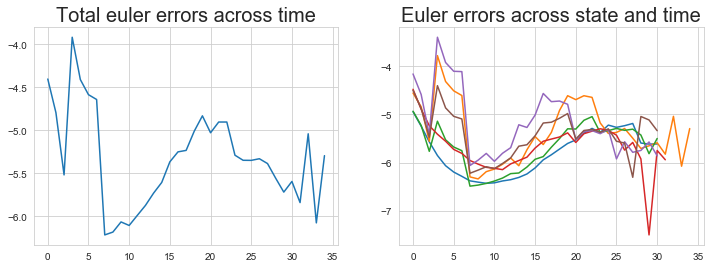

In [22]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
all_times = list(range(len(model.sim.euler)))
axs[0].set_title('Total euler errors across time',size=20)
axs[0].plot(log_euler(model,time=all_times))

axs[1].set_title('Euler errors across state and time',size=20)
for st in np.unique(model.sim.states):
    axs[1].plot(log_euler(model,states=st,time=all_times))

plt.show()

### Life cycle

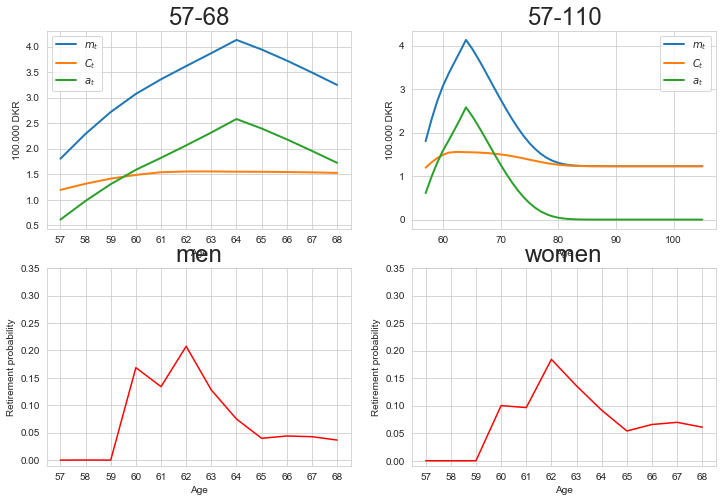

In [23]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(model,axs[0,0])
axs[0,0].set_title('57-68',size=24)
figs.lifecycle(model,axs[0,1],ages=[57,110])
axs[0,1].set_title('57-110',size=24)
figs.retirement_probs(model,axs[1,0],states=[5,6,7])
axs[1,0].set_title('men',size=24)
figs.retirement_probs(model,axs[1,1],states=[1,2,3])
axs[1,1].set_title('women',size=24)
plt.show()

### Zoom in on consumption

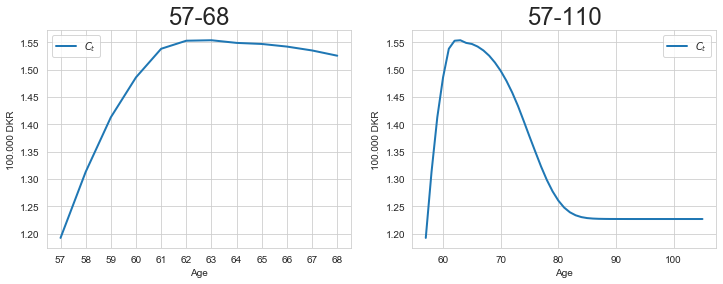

In [24]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title('57-68',size=24)
figs.lifecycle(model,axs[0],vars=['c'])
axs[1].set_title('57-110',size=24)
figs.lifecycle(model,axs[1],vars=['c'],ages=[57,110])

# Time the model and simulation

In [26]:
model = SingleClass(Na=195, poc=5, simN=100000)
model.par.simT=20

In [27]:
def solve():
    model.solve() 
    
def simulate():
    model.simulate()
    
funcs = [solve,simulate]
argu = dict([(funcs[0], []),
             (funcs[1], [])])
names = dict([(funcs[0], 'solve, #a=200'),
              (funcs[1], 'simulate, T=20, N=100000')])

Run model/simulation 100 times

In [28]:
funs.my_timer(funcs,argu,names,unit='s',ndigits=2,Ntimes=1)

time unit is: s
+--------------------------+-------+--------+-------+-------+-------+
|           func           |   lq  | median |  mean |   uq  | neval |
+--------------------------+-------+--------+-------+-------+-------+
|      solve, #a=200       | 37.92 | 37.92  | 37.92 | 37.92 |  1.0  |
| simulate, T=20, N=100000 |  12.9 |  12.9  |  12.9 |  12.9 |  1.0  |
+--------------------------+-------+--------+-------+-------+-------+


In [31]:
funs.my_timer(funcs,argu,names,unit='s',ndigits=2,Ntimes=100)

time unit is: s
+--------------------------+------+--------+------+------+-------+
|           func           |  lq  | median | mean |  uq  | neval |
+--------------------------+------+--------+------+------+-------+
|      solve, #a=200       | 0.99 |  0.99  | 1.0  | 1.0  | 100.0 |
| simulate, T=20, N=100000 | 3.2  |  3.26  | 3.9  | 4.92 | 100.0 |
+--------------------------+------+--------+------+------+-------+
